# MNIST classicifation

In [13]:
# Imports
import torch 
import torchvision
from torchvision.transforms import ToTensor 
import torchvision.transforms as trnsfrms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

In [6]:
# Hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [28]:
# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
# Load training data
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)) # Using the mean and standard deviation of the dataset
                ]),
    download = True,            
), batch_size=batch_size_train, shuffle=True)

# Load test data
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)) # Using the mean and standard deviation of the dataset
                ]),
    download = True, 
), batch_size=batch_size_test, shuffle=True)

torch.Size([1000, 1, 28, 28])


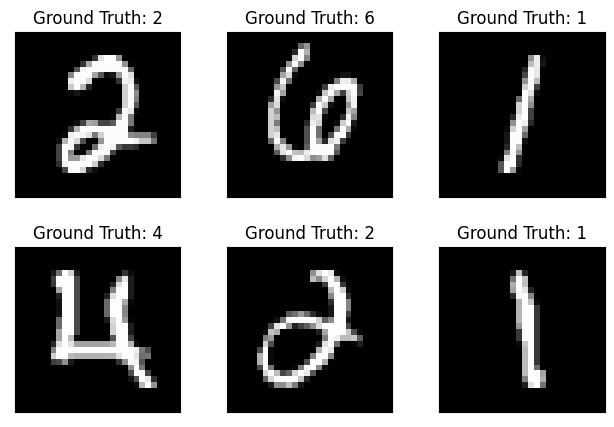

In [12]:
# Visualize data
examples = enumerate(test_loader) # Iterates over all test data
batch_idx, (example_data, example_targets) = next(examples) # Take first batch
print(example_data.shape)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [14]:
# Create model class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Convolution, pooling, and relu activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # Convolution, dropout, pooling, and relu activation
        x = x.view(-1, 320) # Reshape tensors
        x = F.relu(self.fc1(x)) # Fully connected layer and relu activation
        x = F.dropout(x, training=self.training) # Dropout
        x = self.fc2(x) # Fully connected layer
        return F.log_softmax(x) # Softmax layer

In [15]:
# Define net object and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [21]:
# Training history
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# Train loop
def train(epoch):
  
  # Set network in training mode
  network.train()

  # Loop over all batches using the training loader
  for batch_idx, (data, target) in enumerate(train_loader):

    # Reset parameter gradients
    optimizer.zero_grad()

    # Forward pass
    output = network(data)

    # Compute loss
    loss = F.nll_loss(output, target)

    # Calculate new gradients
    loss.backward()

    # Backpropagate
    optimizer.step()

    # Logging
    if batch_idx % log_interval == 0:
      
      # Log
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

      # Save model
      torch.save(network.state_dict(), 'models/model.pth')
      torch.save(optimizer.state_dict(), 'models/optimizer.pth')


In [17]:
# Test loop
def test():

  # Evaluate network on batch
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():

    # Loop over samples
    for data, target in test_loader:

      # Forward pass
      output = network(data)

      # Compute loss
      test_loss += F.nll_loss(output, target, size_average=False).item()

      # Network prediction
      pred = output.data.max(1, keepdim=True)[1]

      # Number of correct predictions
      correct += pred.eq(target.data.view_as(pred)).sum()

  # Accuracy
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [22]:
# Test the network on randomly generated parameters
test()

# Loop over all epochs
for epoch in range(1, n_epochs + 1):
  
  # Train
  train(epoch)

  # Test
  test()

C:\Users\matth\AppData\Local\Temp\ipykernel_22416\2661028983.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3095, Accuracy: 1255/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321094
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.307057
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.291631
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.307304
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.251200
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.267509
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.210683
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.106591
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.109231
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.032450
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.062181
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.972388
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.793966
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.794658
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.687232
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.563035
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.602946
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.415417
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.269590
Train Epoch: 1 [12160

Text(0, 0.5, 'negative log likelihood loss')

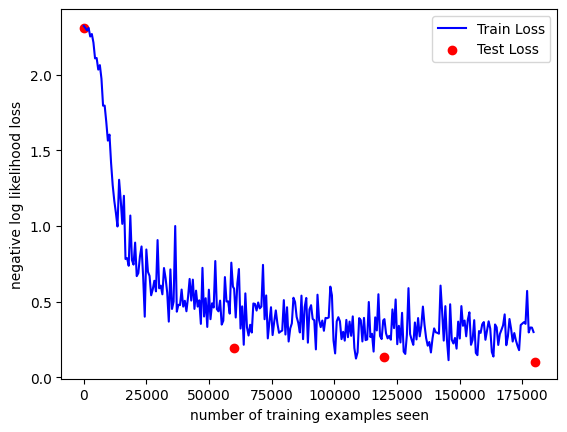

In [23]:
# Plot training curve
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

C:\Users\matth\AppData\Local\Temp\ipykernel_22416\2661028983.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


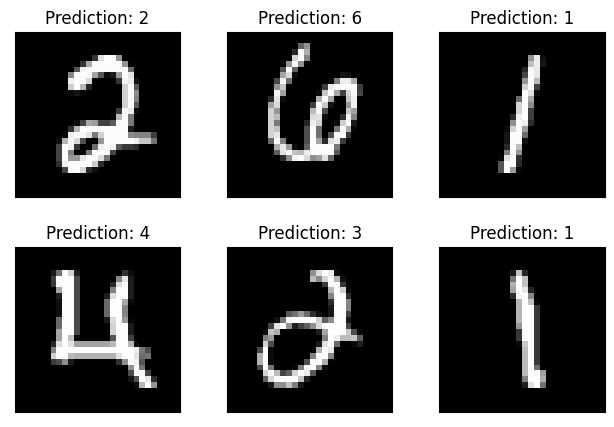

In [24]:
# Predict somee samples
with torch.no_grad():
  output = network(example_data)

# Plot
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

### Continued training from checkpoints

In [26]:
# Create new net and optimizer
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

# Load pretrained network
network_state_dict = torch.load('models/model.pth')
continued_network.load_state_dict(network_state_dict)

# Load optimizer status
optimizer_state_dict = torch.load('models/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [27]:
# Retrain for 5 more epochs
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

C:\Users\matth\AppData\Local\Temp\ipykernel_22416\2661028983.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.238794
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.208070
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.181401
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.147867
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.298016
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.210767
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.249626
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.468794
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.186211
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.276840
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.149270
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.323306
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.232168
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.272904
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.243190
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.295031
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.194250
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.172806
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.253284
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.251268
Train Epoch: 4 [12800/60000 (

c:\Python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0873, Accuracy: 9711/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.438678
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.197273
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.145439
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.273799
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.288896
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.251286
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.107009
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.395226
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.157511
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.164588
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.256139
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.231501
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.212405
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.210246
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.237915
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.279516
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.145382
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.323539
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.261622
Train Epoch: 5 [12160

Text(0, 0.5, 'negative log likelihood loss')

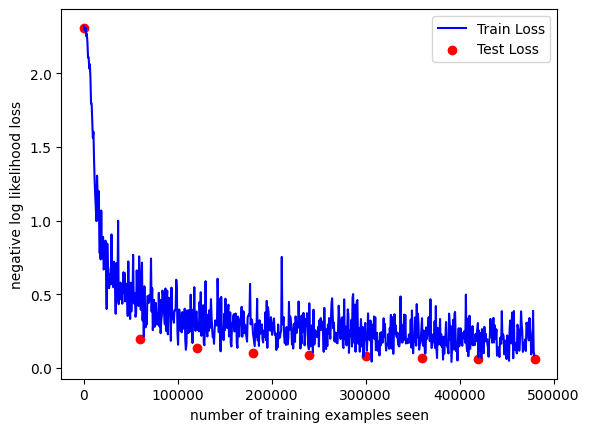

In [29]:
# Evaluate network
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')